# Diffusion Models

Screen Shot 2025-07-22 at 12.57.17.png

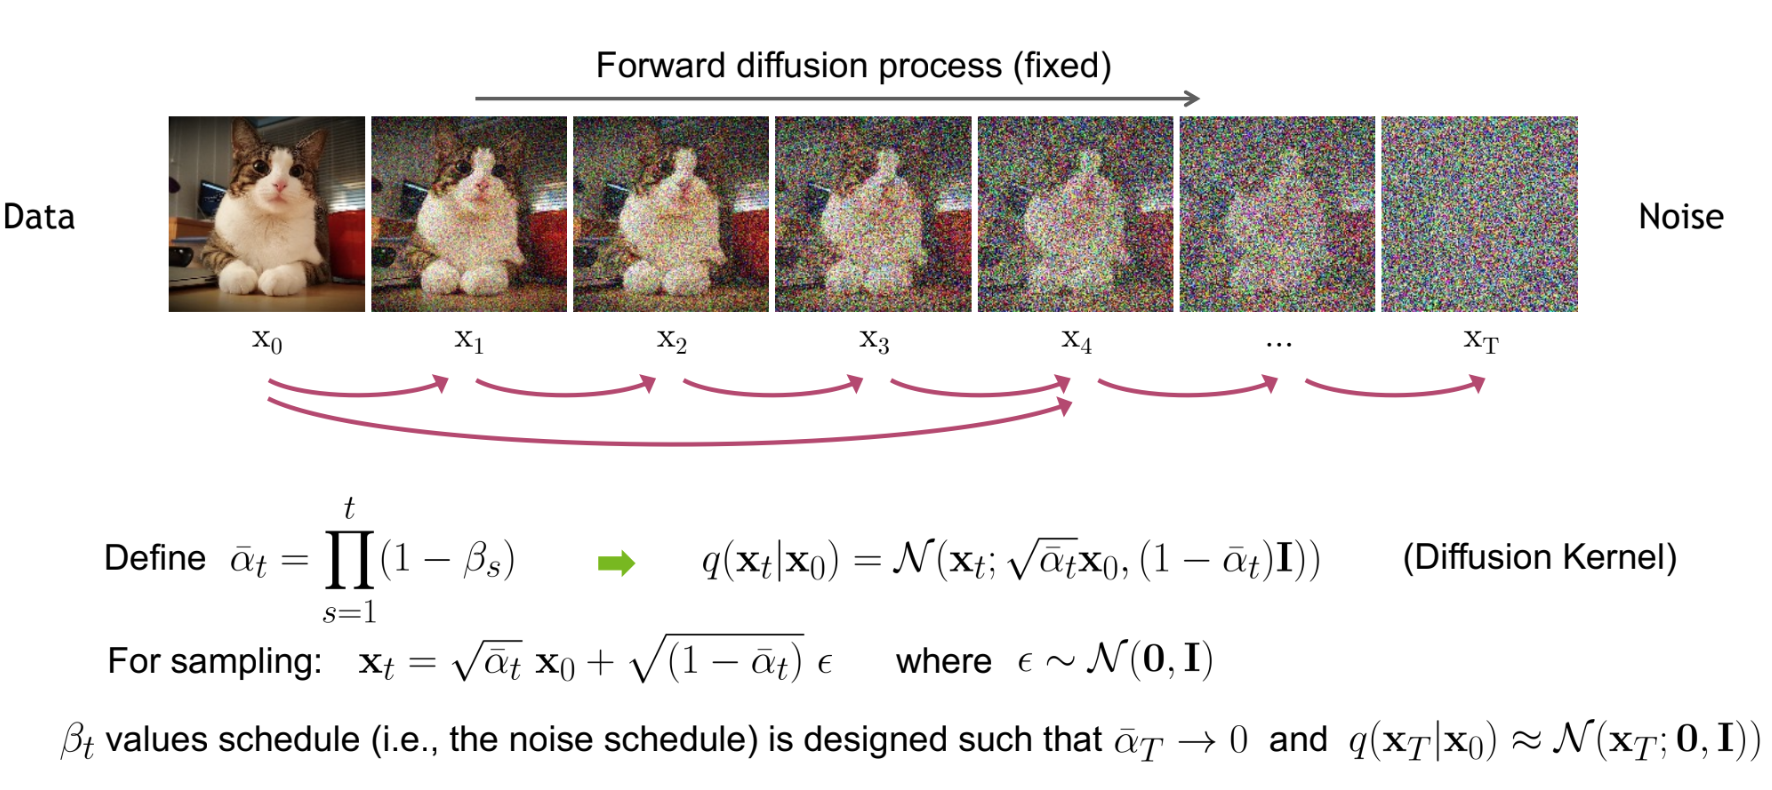

Screen Shot 2025-07-22 at 13.01.28.png

In [1]:
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Create a Linear Noise Schedule

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

T = 100  # total diffusion steps
beta = torch.linspace(1e-4, 0.02, T)  # small to moderate noise
alpha = 1. - beta
alpha_hat = torch.cumprod(alpha, dim=0).to(device)
print(alpha_hat)
print(beta)

Using device: cuda
tensor([0.9999, 0.9996, 0.9991, 0.9984, 0.9975, 0.9964, 0.9951, 0.9936, 0.9919,
        0.9900, 0.9879, 0.9856, 0.9832, 0.9805, 0.9776, 0.9746, 0.9713, 0.9679,
        0.9643, 0.9606, 0.9566, 0.9525, 0.9482, 0.9437, 0.9390, 0.9342, 0.9292,
        0.9241, 0.9188, 0.9134, 0.9078, 0.9020, 0.8961, 0.8901, 0.8839, 0.8776,
        0.8712, 0.8646, 0.8579, 0.8511, 0.8442, 0.8371, 0.8300, 0.8227, 0.8154,
        0.8079, 0.8004, 0.7927, 0.7850, 0.7772, 0.7693, 0.7613, 0.7533, 0.7452,
        0.7370, 0.7288, 0.7205, 0.7122, 0.7038, 0.6954, 0.6870, 0.6785, 0.6699,
        0.6614, 0.6528, 0.6442, 0.6356, 0.6270, 0.6184, 0.6097, 0.6011, 0.5924,
        0.5838, 0.5752, 0.5666, 0.5580, 0.5494, 0.5408, 0.5323, 0.5238, 0.5153,
        0.5069, 0.4985, 0.4901, 0.4818, 0.4735, 0.4653, 0.4571, 0.4489, 0.4409,
        0.4329, 0.4249, 0.4170, 0.4092, 0.4014, 0.3937, 0.3860, 0.3785, 0.3710,
        0.3636], device='cuda:0')
tensor([1.0000e-04, 3.0101e-04, 5.0202e-04, 7.0303e-04, 9.0404e-04,

# Training and Sampling

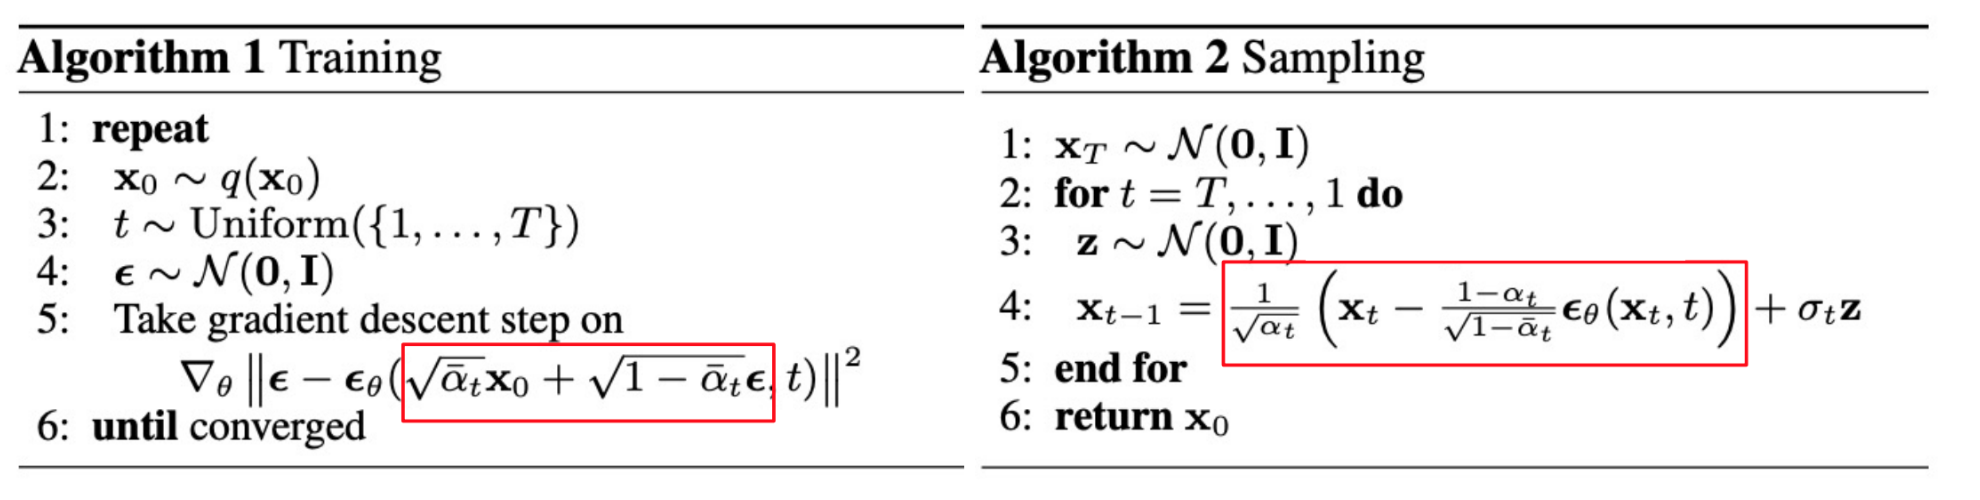

# Forward Process

In [3]:
def forward_diffusion_sample(x_0, t):
    """
    x_0: original image
    t: timestep (int)
    Returns: x_t, noise
    """
    noise = torch.randn_like(x_0)
    sqrt_alpha_hat = torch.sqrt(alpha_hat[t])[:, None, None, None]
    sqrt_one_minus_alpha_hat = torch.sqrt(1 - alpha_hat[t])[:, None, None, None]
    x_t = sqrt_alpha_hat * x_0 + sqrt_one_minus_alpha_hat * noise
    return x_t, noise

# Simple Noise Prediction Model

In [4]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(2, 32, 3, padding=1), nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1), nn.ReLU(),
            nn.Conv2d(32, 1, 3, padding=1)
        )

    def forward(self, x):
        return self.net(x)


# Training

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x * 2 - 1)  # scale to [-1, 1]
])

dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
loader = DataLoader(dataset, batch_size=128, shuffle=True)

model = SimpleCNN().to(device=device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
loss_fn = nn.MSELoss()

# Move noise schedule to the device
alpha = alpha.to(device)
beta = beta.to(device)
alpha_hat = alpha_hat.to(device)

for epoch in range(25):
    for x, _ in loader:
        x = x.to(device=device)
        t = torch.randint(0, T, (x.shape[0],), device=device)
        x_t, noise = forward_diffusion_sample(x, t)
        t_expanded = (t[:, None, None, None].float() / T).expand_as(x_t)

        x_input = torch.cat([x_t, t_expanded], dim=1)

        predicted_noise = model(x_input)
        loss = loss_fn(predicted_noise, noise)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch}: {loss.item():.4f}")

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.01MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 57.5kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.25MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.3MB/s]


Epoch 0: 0.1168
Epoch 1: 0.0949
Epoch 2: 0.1011
Epoch 3: 0.1031
Epoch 4: 0.0980
Epoch 5: 0.0924
Epoch 6: 0.0827
Epoch 7: 0.0787
Epoch 8: 0.0943
Epoch 9: 0.0859
Epoch 10: 0.1001
Epoch 11: 0.0928
Epoch 12: 0.0828
Epoch 13: 0.0802
Epoch 14: 0.0786
Epoch 15: 0.0780
Epoch 16: 0.0828
Epoch 17: 0.0791
Epoch 18: 0.0810
Epoch 19: 0.0830
Epoch 20: 0.0772
Epoch 21: 0.0753
Epoch 22: 0.0707
Epoch 23: 0.0740
Epoch 24: 0.0741


# Sampling

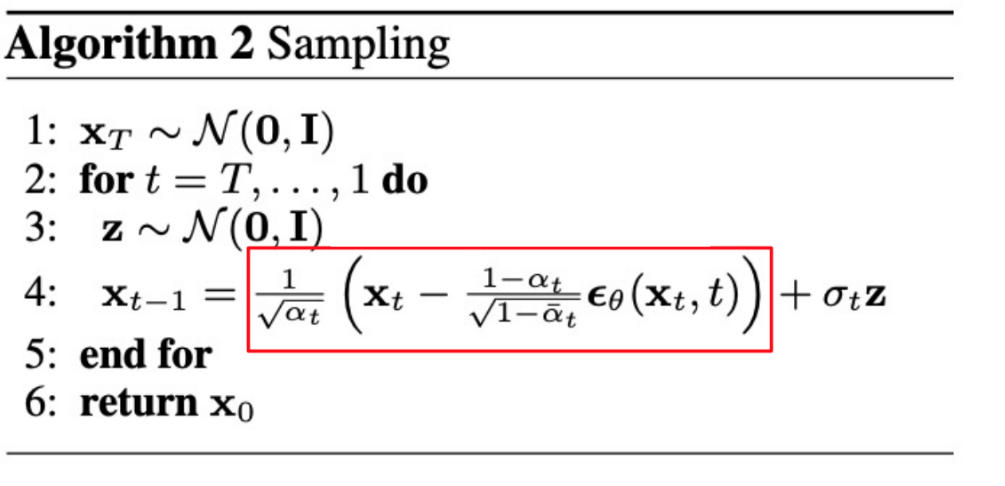

In [6]:
@torch.no_grad()
def sample(model, n=16, device='cpu'):
    model.eval()
    x = torch.randn(n, 1, 28, 28).to(device)
    # Ensure alpha, beta, and alpha_hat are on the correct device
    local_alpha = alpha.to(device)
    local_beta = beta.to(device)
    local_alpha_hat = alpha_hat.to(device)

    for t in reversed(range(T)):

        t_batch = torch.full((n,), t, device=device)

        # Naive time embedding
        t_emb = (t_batch[:, None, None, None].float() / T).expand_as(x)

        x_input = torch.cat([x, t_emb], dim=1)
        predicted_noise = model(x_input)

        alpha_t = local_alpha[t]
        alpha_hat_t = local_alpha_hat[t]
        beta_t = local_beta[t]


        if t > 0:
            noise = torch.randn_like(x)
        else:
            noise = 0

        x = (1 / torch.sqrt(alpha_t)) * (x - ((1 - alpha_t) / torch.sqrt(1 - alpha_hat_t)) * predicted_noise) + torch.sqrt(beta_t) * noise

    return x


samples = sample(model, n=16, device=device) # Pass device to sample function
samples = (samples.clamp(-1, 1) + 1) / 2  # back to [0, 1]
grid = torchvision.utils.make_grid(samples, nrow=4)
plt.imshow(grid.permute(1, 2, 0).cpu()) # Move tensor to CPU before plotting
plt.title("Dummy Diffusion Model Samples")
plt.axis("off")
plt.show()

# A more complex model: Unet

Screen Shot 2025-07-22 at 15.47.48.png

In [8]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

# ---------- Time embedding ----------
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
    def forward(self, t):
        half = self.dim // 2
        freqs = torch.exp(-torch.arange(half, device=t.device).float() *
                          (math.log(10000) / (half - 1)))
        args = t[:, None].float() * freqs[None]
        return torch.cat([torch.sin(args), torch.cos(args)], dim=-1)  # [B, dim]

# ---------- Residual block ----------
class ResBlock(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim):
        super().__init__()
        self.norm1 = nn.GroupNorm(8, in_ch)
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.norm2 = nn.GroupNorm(8, out_ch)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.time_mlp = nn.Linear(time_emb_dim, out_ch)
        self.res_conv = nn.Conv2d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()

    def forward(self, x, t_emb):
        h = F.silu(self.norm1(x))
        h = self.conv1(h)
        h = h + self.time_mlp(t_emb)[:, :, None, None]
        h = F.silu(self.norm2(h))
        h = self.conv2(h)
        return h + self.res_conv(x)

# ---------- Down / Up (no args) ----------
class Downsample(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        return F.avg_pool2d(x, 2)

class Upsample(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        return F.interpolate(x, scale_factor=2, mode="nearest")

# ---------- U-Net ----------
class UNetDenoiser(nn.Module):
    def __init__(self, in_channels=1, base_ch=64, channel_mults=(1, 2, 4), time_emb_dim=256):
        super().__init__()
        # time embedding MLP
        self.time_emb = nn.Sequential(
            SinusoidalPosEmb(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim * 4),
            nn.SiLU(),
            nn.Linear(time_emb_dim * 4, time_emb_dim),
        )

        self.init_conv = nn.Conv2d(in_channels, base_ch, 3, padding=1)

        # Down path
        downs = []
        ch = base_ch
        for i, mult in enumerate(channel_mults):
            out_ch = base_ch * mult
            downs.append(ResBlock(ch, out_ch, time_emb_dim))
            ch = out_ch
            if i != len(channel_mults) - 1:
                downs.append(Downsample())
        self.downs = nn.ModuleList(downs)

        # Bottleneck
        self.bottleneck = ResBlock(ch, ch, time_emb_dim)

        # Up path (mirror)
        ups = []
        for i, mult in reversed(list(enumerate(channel_mults))):
            if i != len(channel_mults) - 1:
                ups.append(Upsample())
            skip_ch = base_ch * mult
            ups.append(ResBlock(ch + skip_ch, skip_ch, time_emb_dim))
            ch = skip_ch
        self.ups = nn.ModuleList(ups)

        self.final_conv = nn.Sequential(
            nn.GroupNorm(8, ch),
            nn.SiLU(),
            nn.Conv2d(ch, 1, 3, padding=1),
        )

    def forward(self, x, t):
        t_emb = self.time_emb(t)
        h = self.init_conv(x)

        skips = []
        for layer in self.downs:
            if isinstance(layer, ResBlock):
                h = layer(h, t_emb)
                skips.append(h)
            else:
                h = layer(h)  # Downsample

        h = self.bottleneck(h, t_emb)

        for layer in self.ups:
            if isinstance(layer, Upsample):
                h = layer(h)
            else:  # ResBlock
                skip = skips.pop()
                if skip.shape[-2:] != h.shape[-2:]:
                    skip = skip[:, :, :h.size(2), :h.size(3)]
                h = torch.cat([h, skip], dim=1)
                h = layer(h, t_emb)

        return self.final_conv(h)

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x * 2 - 1)  # scale to [-1, 1]
])

dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
loader = DataLoader(dataset, batch_size=128, shuffle=True)

model = UNetDenoiser(
    in_channels=1,
    base_ch=64,
    channel_mults=(1, 2, 4),
    time_emb_dim=256
).to(device)



optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
loss_fn = nn.MSELoss()

# Move noise schedule to the device
alpha = alpha.to(device)
beta = beta.to(device)
alpha_hat = alpha_hat.to(device)

for epoch in range(25):
    for x, _ in loader:
        x = x.to(device)

        # sample timesteps
        t = torch.randint(0, T, (x.size(0),), device=device, dtype=torch.long)

        # forward diffusion
        x_t, noise = forward_diffusion_sample(x, t)


        predicted_noise = model(x_t, t)

        loss = loss_fn(predicted_noise, noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch}: {loss.item():.4f}")


Epoch 0: 0.0752
Epoch 1: 0.0684
Epoch 2: 0.0596
Epoch 3: 0.0607
Epoch 4: 0.0554
Epoch 5: 0.0568
Epoch 6: 0.0596
Epoch 7: 0.0629
Epoch 8: 0.0583
Epoch 9: 0.0551
Epoch 10: 0.0615
Epoch 11: 0.0561
Epoch 12: 0.0566
Epoch 13: 0.0550
Epoch 14: 0.0585
Epoch 15: 0.0561
Epoch 16: 0.0572
Epoch 17: 0.0547
Epoch 18: 0.0590
Epoch 19: 0.0514
Epoch 20: 0.0569
Epoch 21: 0.0542
Epoch 22: 0.0558
Epoch 23: 0.0572
Epoch 24: 0.0523


In [10]:
@torch.no_grad()
def sample(model, n=16, device="cpu"):
    model.eval()

    # put schedules on device once
    a      = alpha.to(device)
    b      = beta.to(device)
    a_hat  = alpha_hat.to(device)

    x = torch.randn(n, 1, 28, 28, device=device)

    for t in reversed(range(T)):
        t_batch = torch.full((n,), t, device=device, dtype=torch.long)

        pred_noise = model(x, t_batch)

        a_t     = a[t]
        a_hat_t = a_hat[t]
        b_t     = b[t]

        if t > 0:
            z = torch.randn_like(x)
        else:
            z = 0

        x = (1.0 / torch.sqrt(a_t)) * (
                x - ((1 - a_t) / torch.sqrt(1 - a_hat_t)) * pred_noise
            ) + torch.sqrt(b_t) * z

    return x

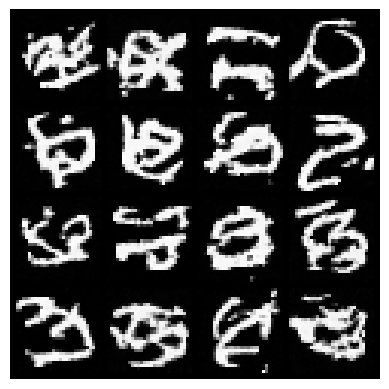

In [11]:
samples = sample(model, n=16, device=device)
samples = (samples.clamp(-1, 1) + 1) / 2
grid = torchvision.utils.make_grid(samples, nrow=4)
plt.imshow(grid.permute(1, 2, 0).cpu())
plt.axis("off")
plt.show()
